In [1]:
from pathlib import Path

data_dir = Path("data")
data_paths = sorted(data_dir.glob("*.csv"))
data_paths

[PosixPath('data/40secondblinkwithlaps.csv'),
 PosixPath('data/40seconddoubleblink.csv'),
 PosixPath('data/40seconddoublelookleft.csv'),
 PosixPath('data/40seconddoublelookright.csv'),
 PosixPath('data/40secondlookleftlaps.csv'),
 PosixPath('data/40secondlookrightlaps.csv')]

In [2]:
import numpy as np

laps_txt = data_dir / "laps.txt"

def load_data(path, with_laps=laps_txt, reverse=True):
    if with_laps:
        name = path.stem
        laps = []
        found = False
        with open(laps_txt) as f:
            for line in f.readlines():
                line = line.strip()
                if not line:
                    pass
                elif not line.replace(".", "").isnumeric():
                    if found:
                        break
                    if name == line:
                        found = True
                elif found:
                    laps.append(float(line))
            laps = np.cumsum(np.array(laps))
    arr = np.genfromtxt(path, delimiter=",")
    time, amp = arr.T
    if reverse:
        time = np.max(time) - time
    return time, amp, laps if len(laps) else None

data = load_data(next(data_dir.glob("*blinkwithlaps.csv")))
time, amp, laps = data

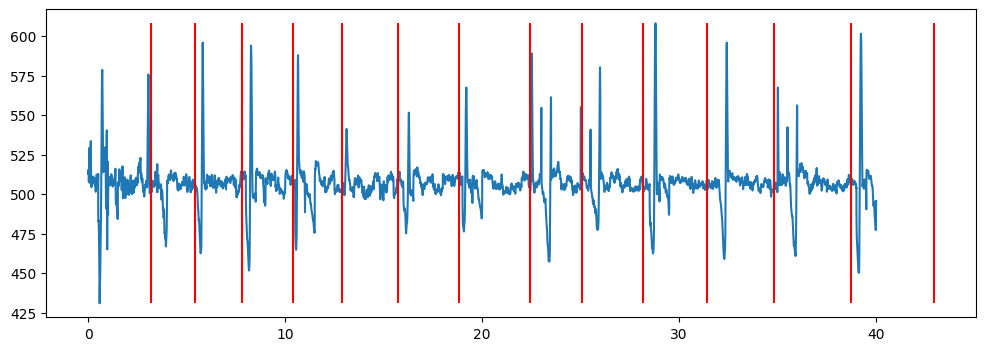

In [3]:
import matplotlib.pyplot as plt

def plot_data(time, amp, laps=None, /, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(time, amp)
    if laps is not None:
        ax.vlines(laps, np.min(amp), np.max(amp),
                  color="red")

plt.figure(figsize=(12, 4))
plot_data(time, amp, laps)
plt.show()

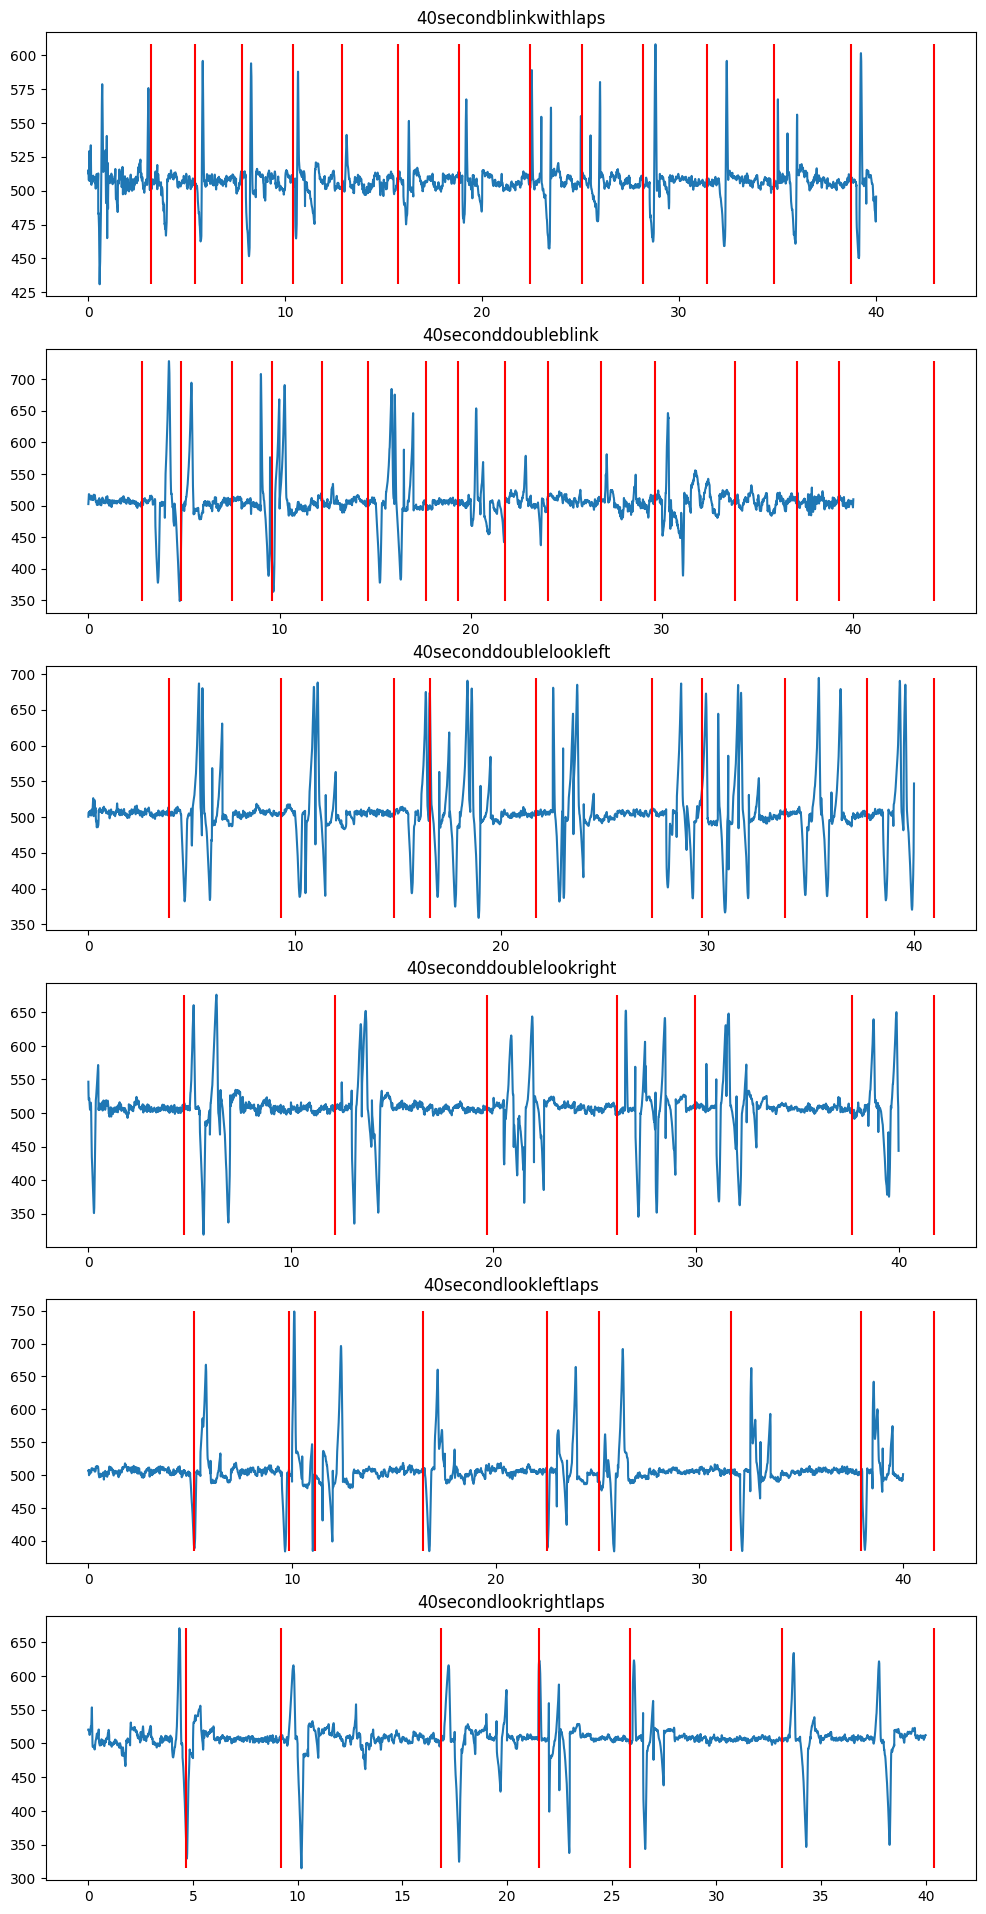

In [4]:
fig, axes = plt.subplots(len(data_paths), 1, figsize=(12, 4 * len(data_paths)))
for ax, path in zip(axes, data_paths):
    time, amp, laps = load_data(path)
    plot_data(time, amp, laps, ax=ax)
    ax.set_title(path.stem)
plt.show()

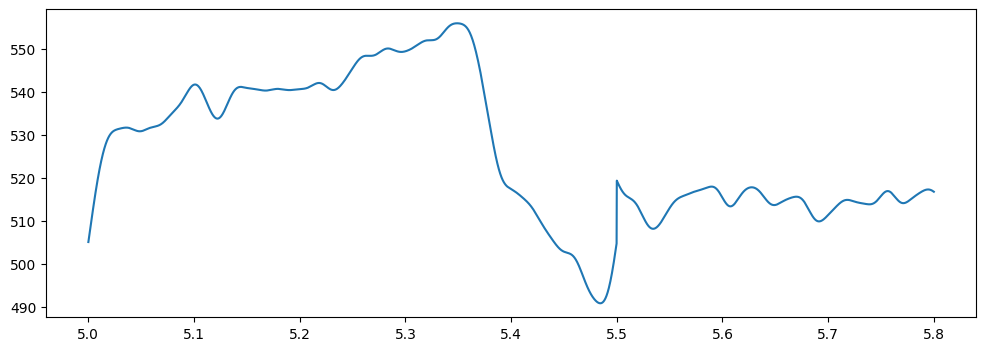

In [5]:
def sliding_window(time,
                   amp,
                   laps=None,
                   window_sec=0.8,
                   window_inc=0.2):
    n_window = int((max(time) - window_sec) // window_inc)
    for i in range(n_window):
        start_sec = window_inc * i
        end_sec = start_sec + window_sec
        mask = (start_sec <= time) & (time < end_sec)
        if laps is not None:
            laps = laps[(start_sec <= laps) & (laps < end_sec)]
            yield time[mask], amp[mask], laps
        else:
            yield time[mask], amp[mask]

windows = sliding_window(time, amp, laps)
for _ in range(25):
    next(windows)
window_time, window_amp, window_laps = next(windows)
plt.figure(figsize=(12, 4))
plot_data(window_time, window_amp, window_laps)
plt.show()

In [6]:
# mean of amplitude in all data
amp_mean = np.mean(np.concatenate([load_data(path)[1] for path in data_paths]))
amp_mean

506.3047830254177

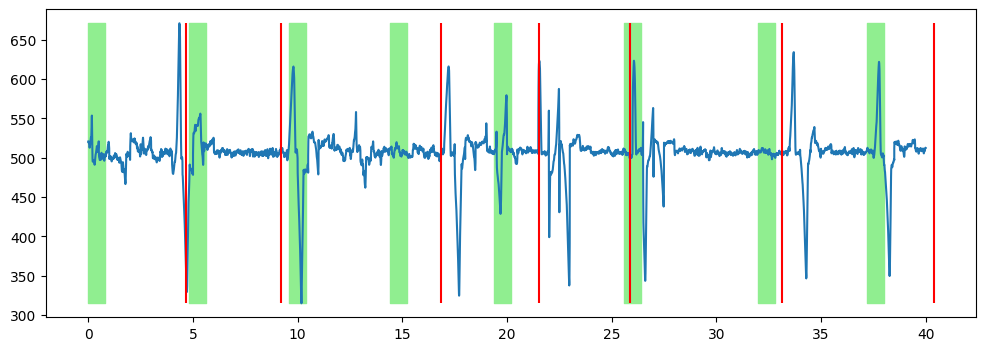

In [7]:
def zero_crossing_event_classifier(amp, mean=amp_mean, threshold=0.001):
    amp -= mean
    count = np.sum(amp[:-1] * amp[1:] < 0)
    return count <= len(amp) * threshold

def predict_event(time, amp, event_classifier,
                  window_sec=1.2,
                  window_inc=0.05,
                  event_skip=None):
    if event_skip is None:
        event_skip = int(window_sec // window_inc)
    windows = sliding_window(time, amp)
    while (window := next(windows, None)) is not None:
        window_time, window_amp = window
        has_event = event_classifier(window_amp)
        if has_event:
            yield min(window_time), max(window_time)
            for _ in range(event_skip):
                next(windows, None)

events = [*predict_event(time, amp, zero_crossing_event_classifier)]
plt.figure(figsize=(12, 4))
for event in events:
    plt.fill_between(event, min(amp), max(amp), color="lightgreen")
plot_data(time, amp, laps)
plt.show()

In [8]:
single_paths = [*filter(lambda path: "double" not in str(path), data_paths)]
single_paths

[PosixPath('data/40secondblinkwithlaps.csv'),
 PosixPath('data/40secondlookleftlaps.csv'),
 PosixPath('data/40secondlookrightlaps.csv')]

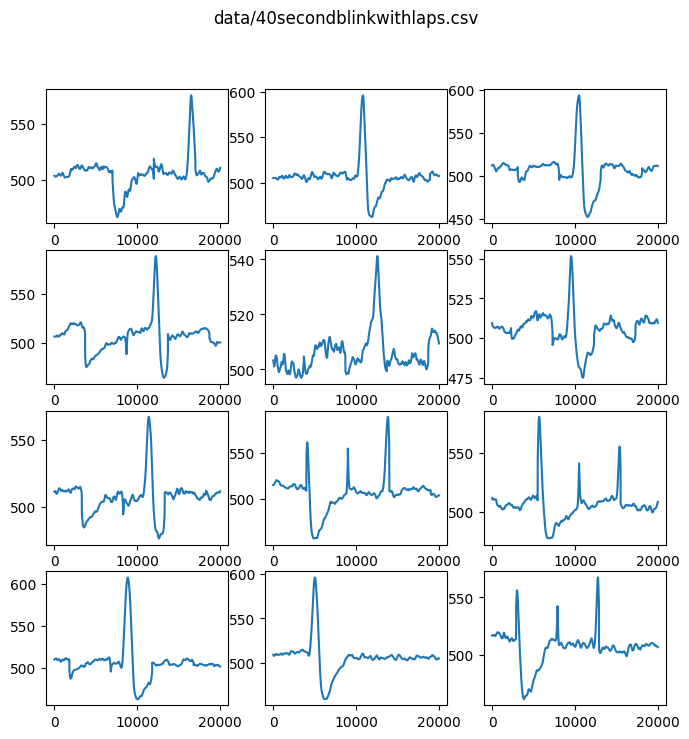

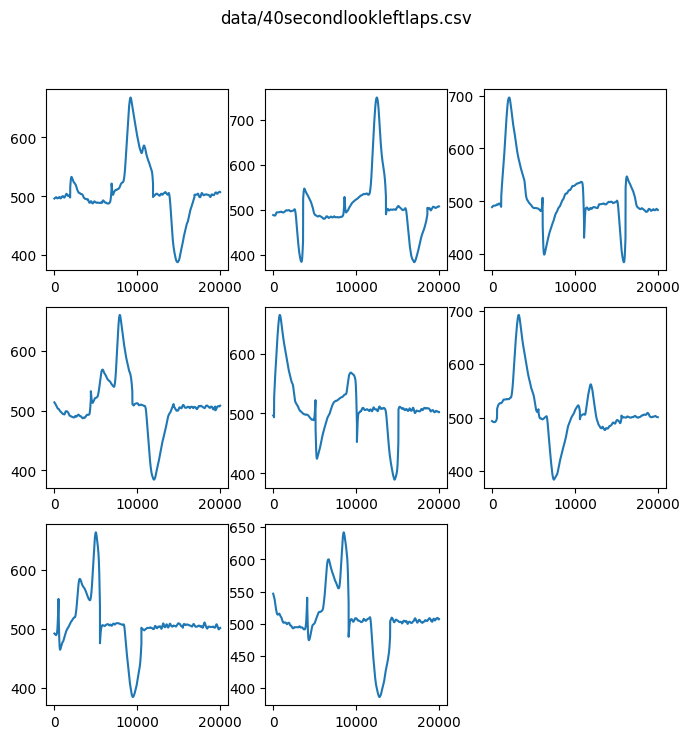

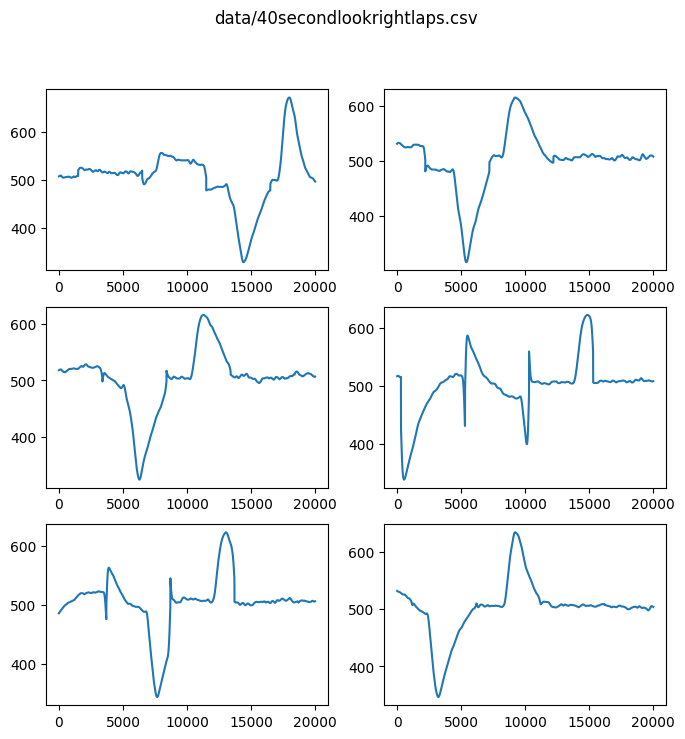

In [9]:
from itertools import zip_longest

offset_sec = -0.5
clip_sec = 2.0

labeled_clips = {}

for path in single_paths:
    time, amp, laps = load_data(path)
    for lap in laps:
        start_sec = lap + offset_sec
        end_sec = lap + offset_sec + clip_sec
        if 0 <= start_sec and end_sec <= np.max(time):
            mask = (start_sec <= time) & (time < end_sec)
            labeled_clips.setdefault(path, []).append(amp[mask])

for path, clips in labeled_clips.items():
    a = int(np.ceil(np.sqrt(len(clips))))
    b = int(np.ceil(len(clips) / a))
    fig, axes = plt.subplots(a, b, figsize=(8, 8))
    fig.suptitle(path)
    for ax, clip in zip_longest(axes.flatten(), clips):
        if clip is None:
            ax.remove()
            continue
        ax.plot(clip)
plt.show()